In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/RecSys/data.csv')

### Анализ

Эту часть работы сделаем не в функции, а в отдельных ячейках, так удобнее наблюдать, что происходит с датасетом. Сначала удалим ненужные столбцы

In [4]:
to_drop = ["oaid_hash", "banner_id0", "banner_id1", "rate0", "rate1", "g0", "g1", "coeff_sum0", "coeff_sum1"]
data = data.drop(to_drop, axis=1)
data.head()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,0,0,0,1,1
1,2021-09-26 22:54:49.000000,1,1,0,0,1,1,1
2,2021-09-26 23:57:20.000000,2,2,3,0,0,1,1
3,2021-09-27 00:04:30.000000,3,3,0,1,1,1,1
4,2021-09-27 00:06:21.000000,4,4,0,1,0,1,1


Посмотрим на столбец impressions, пока кажется, что он не несет информации.

In [5]:
data.groupby("impressions").count()

,date_time,zone_id,banner_id,campaign_clicks,os_id,country_id,clicks
impressions,,,,,,,
1,15821472,15821472,15821472,15821472,15821472,15821472,15821472


In [6]:
data = data.drop("impressions", axis=1)

Проверим, есть ли None:

In [7]:
data.isnull().value_counts()

date_time  zone_id  banner_id  campaign_clicks  os_id  country_id  clicks
False      False    False      False            False  False       False     15821472
dtype: int64

Таких значений нет, чистить датасет не нужно. Посмотрим на статистику по дням

In [8]:
data["date_time"] = pd.to_datetime(data["date_time"])
data['date'] = data.date_time.dt.date
data.date.value_counts()

2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
2021-09-01          1
Name: date, dtype: int64

По одному из дней только одна запись, выбросим его.

In [9]:
import datetime
data = data.drop(data[data["date"] == datetime.date(2021, 9, 1)].index.asi8)
data = data.sort_values(by='date')
data.date.value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Index.asi8 is deprecated and will be removed in a future version
  


2021-09-26    3102610
2021-09-29    2420588
2021-09-27    2367303
2021-09-28    2307355
2021-10-02    2128978
2021-09-30    1851189
2021-10-01    1643448
Name: date, dtype: int64

Из данной в README информации можно сделать вывод, что все фичи, кроме campaign_click, категориальные. К ним в последствии применим One Hot encoding. Посмотрим ближе на величину campaign cliсks - насколько велики значения, какое распределение

In [10]:
data.campaign_clicks.max()

829

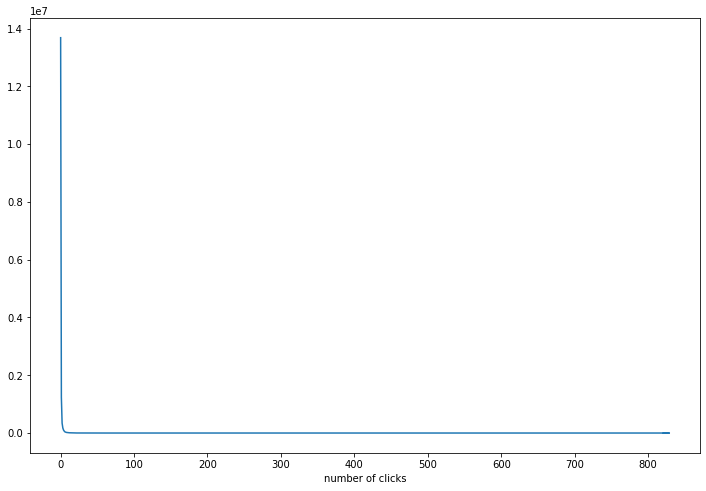

In [11]:
data.campaign_clicks.value_counts().plot(figsize=(12, 8), xlabel="number of clicks", xticks=np.arange(0, 900, 100))

Видим, что распределение перекошено. Было бы хорошо придумать такое преобразование, которое бы "растянуло" распределение, то есть область маленьких величин сделало пошире, а больших сгладило. В таких случаях обычно используют логарифм.

### Feature engineering

Применим One hot encoding:

In [12]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

def feature_engineering(data: pd.DataFrame):
    #делим на train/test
    train = data[data["date"] < datetime.date(2021, 10, 2)]
    test = data[data["date"] == datetime.date(2021, 10, 2)]

    x_train = train.drop(["clicks", "date", "date_time", "campaign_clicks"], axis=1)
    y_train = np.array(train["clicks"])
    x_test = test.drop(["clicks", "date", "date_time", "campaign_clicks"], axis=1)
    y_test = np.array(test["clicks"])

    #преобразуем данные
    #используем разреженные матрицы, поскольку OHE преимущественно нули
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)
    x_train = ohe.fit_transform(x_train)
    print("OHE train transformed")
    #print(type(x_train))
    x_train = hstack([x_train, np.log(np.array(train['campaign_clicks']+1e-4))[:, np.newaxis]])
    x_test = ohe.transform(x_test)
    x_test = hstack([x_test, np.log(np.array(test['campaign_clicks'])+1e-4)[:, np.newaxis]])
    return x_train, x_test, y_train, y_test

In [13]:
x_train, x_test, y_train, y_test = feature_engineering(data)

OHE train transformed


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

### Модель

Будем использовать линейную регрессию с не SGD-like оптимизатором. Я выбрала liblinear, он удобнее всего в использовании с моделью из sklearn.

In [15]:
def create_model(penalty='l1', C=1.0):
    model = LogisticRegression(penalty=penalty, C=C, solver='liblinear')
    return model

In [16]:
def cv(X_train, y_train, l='l1'):
  # данных для кросс валидации достаточно мало, но проблема в том, что в collab переполняется ОЗУ
  # и я не придумала, как с этим справиться
  # а на личном компьютере совсем не работает
    c_ = [0.001, 0.01, 0.1, 1.0]

    for C in c_:
        print(C)
        model = create_model(C=C, penalty=l)
        scores = cross_validate(model, X_train, y_train, scoring=['neg_log_loss', 'roc_auc'], cv=3)
        #print(scores)
        print(f"C = {C}, penalty = {l}, NLL = {np.mean(scores['test_neg_log_loss'])}, ROC AUC = {np.mean(scores['test_roc_auc'])}")
#


Проведем исследования для L2 регуляризации.

In [17]:
cv(x_train, y_train, l='l2')

0.001
C = 0.001, penalty = l2, NLL = -0.11174569911760525, ROC AUC = 0.7244093086026079
0.01
C = 0.01, penalty = l2, NLL = -0.11835203033182666, ROC AUC = 0.7302093283734349
0.1
C = 0.1, penalty = l2, NLL = -0.13122586334861944, ROC AUC = 0.7202240860768595
1.0
C = 1.0, penalty = l2, NLL = -0.15937981249419766, ROC AUC = 0.7098655871014096


In [40]:
model = create_model(C=0.01, penalty='l2')
model.fit(x_train, y_train)

LogisticRegression(C=0.01, solver='liblinear')

In [39]:
from sklearn.metrics import log_loss, roc_auc_score
y_model = model.predict_proba(x_test)[:, 1]
y_base = np.mean(y_test)*np.ones(y_test.shape)
print(f"My model: NNL = {log_loss(y_test, y_model)}, ROC AUC = {roc_auc_score(y_test, y_model)}")
print(f"Baseline: NNL = {log_loss(y_test, y_base)}, ROC AUC = {roc_auc_score(y_test, y_base)}")

float64
My model: NNL = 0.13363618401953573, ROC AUC = 0.7789599619007965
Baseline: NNL = 0.153032899049186, ROC AUC = 0.5


Даже используя только L2 loss, мы смогли побить бейзлайн. С L2 лоссом у меня возникли проблемы подсчета, вылетал коллаб. То, что удалось сосчитать:

In [ ]:
cv(x_train, y_train, l='l1')

0.001
C = 0.001, penalty = l1, NLL = -0.11471927480200289, ROC AUC = 0.7139811447445098
0.1
